In [1]:
import sys
sys.path.insert(0,'..')
from IPython.display import display, HTML
if not sys.warnoptions:
    import warnings
# import imblearn
from collections import Counter
from sklearn.preprocessing import LabelEncoder
# from imblearn.over_sampling import SMOTE
from matplotlib.ticker import PercentFormatter
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.constants as const
from astropy.cosmology import WMAP9 as cosmo
from datetime import datetime
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
from ast import literal_eval
from matplotlib.cm import register_cmap
# from matplotlib_venn import venn3
import seaborn as sns
from numpy.lib.stride_tricks import as_strided
import pickle
from scipy import stats
from datetime import datetime
# from spectral_cube import SpectralCube
# from imblearn.under_sampling import RandomUnderSampler

## Questions
1. What is so different about the closest plot 1245mosC that there are so many False Positives?
    - Look for ripples
    - MTObjects is singled out as the source finder which returns the largest number of false detections. However, nearly all of them (~ 90%) are in the first spectral window (both in the training and test pointing). In all other spectral windows the behaviour is a lot better. In fact, in most spectral windows MTObjecys is much better than SoFiA and V-Net, which have a larger number of false detections! Likewise, most false detections in V-Net  are in the first spectral window (in the test pointing), and the number drops typically below the levels found with SoFiA in most other windows. I think that this deserves some comments and an explanation. The message that MTObjects finds a lot more false detections than SoFiA and V-Net is simplistic and possibly misleading given these variations as a function of frequency.
2. What is so similar or different about the False Positives?
    - Do they populate the same channels
    - Fig. 8 shows that there is nearly no overlap between the three samples of false detections. This begs the question of what is the difference between the three samples. Do they populate different regions of some parameter space? If so, what are the relevant source parameters, and why do different source finders pick such different false detections? This would likely have important implications for choosing the best source finder for a given HI science question. Alternatively, if the authors can show that no clear difference between the three samples can be found, it will be clear that more work needs to be done to compare these source finders.
3. How did the Random Forest choose which sources to detect?
    - Feature importance and with what ranges
4. Demonstrate asymmetry of mock vs. reak sources between source finding methods
    - Make box-plot per spectral window of the ratio between the total fluxes of the source finding methods
    

In [2]:
freq_dict = {"mask_1245mosB.fits": [1401252439.970,1425092772.001],
"mask_1245mosC.fits": [1381037599.970,1404877932.001],
"mask_1245mosD.fits": [1360822751.970,1384663084.001],
"mask_1245mosE.fits": [1340607911.970,1364448244.001],
"mask_1245mosF.fits": [1320393067.970,1344233400.001],
"mask_1245mosG.fits": [1300178221.970,1324018554.001],
"mask_1245mosH.fits": [1279963378.910,1303803710.941],
"mask_1353mosB.fits": [1401179199.970,1425019532.001],
"mask_1353mosC.fits": [1380964351.970,1404804684.001],
"mask_1353mosD.fits": [1360749511.970,1384589844.001],

"mask_1353mosE.fits": [1340534667.970,1364375000.001],
"mask_1353mosF.fits": [1320319823.970,1344160156.001],
"mask_1353mosG.fits": [1300104979.970,1323945312.001],
"mask_1353mosH.fits": [1279890136.720,1303730468.751]}
freq_df = pd.DataFrame(freq_dict.values(), columns=["freq_1", "freq_2"])
freq_df["file_names"] = freq_dict.keys()
freq_df["freq_1_round"] = np.round(freq_df['freq_1']*1e-6).astype(int).astype(str)
freq_df["freq_2_round"] = np.round(freq_df['freq_2']*1e-6).astype(int).astype(str)
freq_df['freq_labels'] = freq_df[['freq_1_round', 'freq_2_round']].agg('-'.join, axis=1)
freq_df.columns = freq_df.columns.map(''.join)
freq_df['mos_name'] = freq_df.file_names.str.replace("mask_", "").str.replace(".fits", "")
freq_df['mos_name_mask'] = freq_df['mos_name']

## Create Catalogues

In [3]:
# real_cat_df = pd.DataFrame()
# for file in listdir("../../results/catalogs/ground_truth"):
#     if "properties"in file:
#         temp_df = pd.read_csv(f"../../results/catalogs/ground_truth/{file}", index_col=0)
#         temp_df["mos_name"] = file.split("_")[0]
#         temp_df = temp_df.reset_index()
#         real_cat_df = real_cat_df.append(temp_df)
# real_cat_df = real_cat_df.reset_index(drop=True)
# real_cat_df["z_pos"] = ((real_cat_df["bbox-3"]+ real_cat_df["bbox-0"])/2).astype(int)
# real_cat_df["x_pos"] = ((real_cat_df["bbox-4"]+ real_cat_df["bbox-1"])/2).astype(int)
# real_cat_df["y_pos"] = ((real_cat_df["bbox-5"]+ real_cat_df["bbox-2"])/2).astype(int)
# real_cat_df[real_cat_df.type == "real"].to_csv("../../results/catalogs/REAL_catalog.txt")

In [4]:
# mos_names = [i.split("_")[0] for i in listdir("../../results/catalogs/ground_truth") if "inserted" in i]
# mock_galaxy_gt_df = pd.DataFrame()
# k = 0
# for mos_name in mos_names:
#     temp_df1 = pd.read_csv(f"../../results/catalogs/ground_truth/{mos_name}_properties.csv")
#     temp_df2 = pd.read_csv(f"../../results/catalogs/ground_truth/{mos_name}_inserted.csv")
#     temp_df1["z_pos"] = ((temp_df1["bbox-3"]+ temp_df1["bbox-0"])/2).astype(int)
#     temp_df1["x_pos"] = ((temp_df1["bbox-4"]+ temp_df1["bbox-1"])/2).astype(int)
#     temp_df1["y_pos"] = ((temp_df1["bbox-5"]+ temp_df1["bbox-2"])/2).astype(int)
#     overlap_df = pd.merge(temp_df1[temp_df1.type=='mock'], temp_df2, on=["z_pos", "x_pos", "y_pos"], how='outer', indicator=True)
#     left_only = overlap_df[overlap_df._merge == 'left_only']
#     right_only = overlap_df[overlap_df._merge == 'right_only']
#     both = overlap_df[overlap_df._merge == 'both'][overlap_df.columns[:-1]]
#     nearest_overlap_df = pd.DataFrame()
#     for i, row in right_only.iterrows():
#         distances = np.sqrt((left_only.z_pos-row.z_pos)**2 + (left_only.x_pos-row.x_pos)**2 + (left_only.y_pos-row.y_pos)**2)
#         mapped_row = left_only[distances == distances.min()][right_only.columns[:-8]]
#         joined_df = mapped_row.reset_index(drop=True).join(pd.DataFrame([row]).reset_index(drop=True)[["z_pos", "x_pos", "y_pos", "gal_file", "orig_mass", "new_mass", "mos_name"]])
#         joined_df["overlap"] = distances.min()
#         nearest_overlap_df = nearest_overlap_df.append(joined_df)
#     # Take closest if 2
#     nearest_overlap_df.loc[nearest_overlap_df.groupby('label')['overlap'].transform('min').eq(nearest_overlap_df['overlap'])].reset_index(drop=True)
#     nearest_overlap_df = nearest_overlap_df[nearest_overlap_df.columns[:-1]]
#     all_mapped_df = nearest_overlap_df.append(both).reset_index(drop=True)
#     all_mapped_df["mos_name"] == mos_name
#     mock_galaxy_gt_df = mock_galaxy_gt_df.append(all_mapped_df)
# mock_galaxy_gt_df.to_csv("../../results/catalogs/MOCK_catalog.txt")

In [5]:
mock_cat_df = pd.read_csv("../../results/catalogs/MOCK_catalog.txt", index_col=0)
real_cat_df = pd.read_csv("../../results/catalogs/REAL_catalog.txt", index_col=0)
# mock_cat_df.append(real_cat_df).to_csv("../../results/catalogs/MASK_catalog.txt")

In [6]:
mto_cat_df = pd.read_csv("../../results/catalogs/MTO_catalog.txt", index_col=0)
vnet_cat_df = pd.read_csv("../../results/catalogs/VNET_catalog.txt", index_col=0)
sofia_cat_df = pd.read_csv("../../results/catalogs/SOFIA_catalog.txt", index_col=0)
mask_cat_df = pd.read_csv("../../results/catalogs/MASK_catalog.txt", index_col=0)

In [7]:
noise_res = [(15*u.arcsec).to(u.deg), (25*u.arcsec).to(u.deg)]
kpc_lim = [0, 300]
n_vel_lim = [7, 750]
d_width = 0.001666666707*u.deg

In [8]:
cond1 = (
    (mto_cat_df.nx*d_width < noise_res[0]) | (mto_cat_df.ny*d_width < noise_res[1]) | 
    (mto_cat_df.ny_kpc > kpc_lim[1]) | (mto_cat_df.nx_kpc > kpc_lim[1]) |
    (mto_cat_df.n_vel > n_vel_lim[1]) | (mto_cat_df.n_vel < n_vel_lim[0])
)
print(len(mto_cat_df[cond1 & (mto_cat_df.type == 'real')]), "false positives real sources flagged out of ", len(mto_cat_df[mto_cat_df.type == 'real']))
print(len(mto_cat_df[cond1 & (mto_cat_df.type == 'mock')]), "false positives mock sources flagged out of ", len(mto_cat_df[mto_cat_df.type == 'mock']))
mto_cat_df.loc[cond1, 'type'] = np.nan

14 false positives real sources flagged out of  68
23 false positives mock sources flagged out of  618


In [9]:
cond2 = (
    (sofia_cat_df.nx*d_width < noise_res[0]) | (sofia_cat_df.ny*d_width < noise_res[1]) | 
    (sofia_cat_df.ny_kpc > kpc_lim[1]) | (sofia_cat_df.nx_kpc > kpc_lim[1]) |
    (sofia_cat_df.n_vel > n_vel_lim[1]) | (sofia_cat_df.n_vel < n_vel_lim[0])
)
print(len(sofia_cat_df[cond2 & (sofia_cat_df.type == 'real')]), "false positives real sources flagged out of ", len(sofia_cat_df[sofia_cat_df.type == 'real']))
print(len(sofia_cat_df[cond2 & (sofia_cat_df.type == 'mock')]), "false positives mock sources flagged out of ", len(sofia_cat_df[sofia_cat_df.type == 'mock']))
sofia_cat_df.loc[cond2, 'type'] = np.nan

3 false positives real sources flagged out of  194
5 false positives mock sources flagged out of  1228


In [10]:

cond3 = (
    (vnet_cat_df.nx*d_width < noise_res[0]) | (vnet_cat_df.ny*d_width < noise_res[1]) | 
    (vnet_cat_df.ny_kpc > kpc_lim[1]) | (vnet_cat_df.nx_kpc > kpc_lim[1]) |
    (vnet_cat_df.n_vel > n_vel_lim[1]) | (vnet_cat_df.n_vel < n_vel_lim[0])
)
print(len(vnet_cat_df[cond3 & (vnet_cat_df.type == 'real')]), "false positives real sources flagged out of ", len(vnet_cat_df[vnet_cat_df.type == 'real']))
print(len(vnet_cat_df[cond3 & (vnet_cat_df.type == 'mock')]), "false positives mock sources flagged out of ", len(vnet_cat_df[vnet_cat_df.type == 'mock']))

vnet_cat_df.loc[cond3, 'type'] = np.nan

0 false positives real sources flagged out of  137
2 false positives mock sources flagged out of  1707


In [11]:
sofia_cat_df['f1'] = (2*sofia_cat_df.overlap_area/(sofia_cat_df.area_gt + sofia_cat_df.area - sofia_cat_df.overlap_area))
mto_cat_df['f1'] = (2*mto_cat_df.overlap_area/(mto_cat_df.area_gt + mto_cat_df.area - mto_cat_df.overlap_area))
vnet_cat_df['f1'] = (2*vnet_cat_df.overlap_area/(vnet_cat_df.area_gt + vnet_cat_df.area - vnet_cat_df.overlap_area))
sofia_cat_df.loc[sofia_cat_df.f1 < 0.11, 'type'] = np.nan
mto_cat_df.loc[mto_cat_df.f1 < 0.11, 'type'] = np.nan
vnet_cat_df.loc[vnet_cat_df.f1 < 0.11, 'type'] = np.nan

In [12]:
mto_cat_df["log10mass"] = np.log10(mto_cat_df.hi_mass)
vnet_cat_df["log10mass"] = np.log10(vnet_cat_df.hi_mass)
sofia_cat_df["log10mass"] = np.log10(sofia_cat_df.hi_mass)
# mask_cat_df["log10mass"] = np.log10(mass_cat_df.new_mass)
mto_cat_df["max_loc"] = mto_cat_df.max_loc.apply(literal_eval)
vnet_cat_df["max_loc"] = vnet_cat_df.max_loc.apply(literal_eval)
sofia_cat_df["max_loc"] = sofia_cat_df.max_loc.apply(literal_eval)
mask_cat_df["max_loc"] = mask_cat_df.max_loc.apply(literal_eval)
mto_cat_df["max_loc_dist"] = mto_cat_df.max_loc.apply(lambda x: np.sqrt(x[0]**2 + x[1]**2 + x[2]**2))
vnet_cat_df["max_loc_dist"] = vnet_cat_df.max_loc.apply(lambda x: np.sqrt(x[0]**2 + x[1]**2 + x[2]**2))
sofia_cat_df["max_loc_dist"] = sofia_cat_df.max_loc.apply(lambda x: np.sqrt(x[0]**2 + x[1]**2 + x[2]**2))
mask_cat_df["max_loc_dist"] = mask_cat_df.max_loc.apply(lambda x: np.sqrt(x[0]**2 + x[1]**2 + x[2]**2))

C:\Progra~1\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Progra~1\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Real Galaxies:
- V-Net is correct
- SoFiA is +- 1/2 difference
- MTO is +- 10 over

Mock Galaxies:
- All way under - not matching properly
- try with area_gt and nearest max_loc

In [13]:
mos_names = [i.split("_")[0] for i in listdir("../../results/catalogs/ground_truth") if "inserted" in i]
def connect_detections_to_ground_truth(detection_catalogue, gt_catalgue, mos_names, types):
    mapped_df = pd.DataFrame()
    k = 0
    for mos_name in mos_names:
        overlap_df = pd.merge_asof(detection_catalogue[(detection_catalogue.type==types) & (detection_catalogue.mos_name == mos_name)].sort_values('max_loc_dist'), gt_catalgue[(gt_catalgue.type==types) & (gt_catalgue.mos_name == mos_name)].sort_values('max_loc_dist'), on="max_loc_dist", suffixes=("_detection", "_mask"), direction="nearest")
        mapped_df = mapped_df.append(overlap_df)
    return mapped_df


In [14]:
mto_mock_df = connect_detections_to_ground_truth(detection_catalogue=mto_cat_df, gt_catalgue=mask_cat_df, mos_names=mos_names, types="mock").reset_index()
vnet_mock_df = connect_detections_to_ground_truth(detection_catalogue=vnet_cat_df, gt_catalgue=mask_cat_df, mos_names=mos_names, types="mock").reset_index()
sofia_mock_df = connect_detections_to_ground_truth(detection_catalogue=sofia_cat_df, gt_catalgue=mask_cat_df, mos_names=mos_names, types="mock").reset_index()

mto_real_df = connect_detections_to_ground_truth(detection_catalogue=mto_cat_df, gt_catalgue=mask_cat_df, mos_names=mos_names, types="real").reset_index()
vnet_real_df = connect_detections_to_ground_truth(detection_catalogue=vnet_cat_df, gt_catalgue=mask_cat_df, mos_names=mos_names, types="real").reset_index()
sofia_real_df = connect_detections_to_ground_truth(detection_catalogue=sofia_cat_df, gt_catalgue=mask_cat_df, mos_names=mos_names, types="real").reset_index()

sanity check

In [15]:
len(mto_cat_df[(mto_cat_df.type == "mock") & mto_cat_df.mos_name.str.contains("1245")]), len(mto_mock_df[mto_mock_df.mos_name_mask.str.contains("1245")]), len(mto_cat_df[(mto_cat_df.type == "real") & mto_cat_df.mos_name.str.contains("1245")]), len(mto_real_df[mto_real_df.mos_name_mask.str.contains("1245")])

(306, 306, 25, 25)

In [16]:
len(sofia_cat_df[(sofia_cat_df.type == "mock") & sofia_cat_df.mos_name.str.contains("1245")]), len(sofia_mock_df[sofia_mock_df.mos_name_mask.str.contains("1245")]), len(sofia_cat_df[(sofia_cat_df.type == "real") & sofia_cat_df.mos_name.str.contains("1245")]), len(sofia_real_df[sofia_real_df.mos_name_mask.str.contains("1245")])

(625, 625, 112, 112)

In [17]:
len(vnet_cat_df[(vnet_cat_df.type == "mock") & vnet_cat_df.mos_name.str.contains("1245")]), len(vnet_mock_df[vnet_mock_df.mos_name_mask.str.contains("1245")]), len(vnet_cat_df[(vnet_cat_df.type == "real") & vnet_cat_df.mos_name.str.contains("1245")]), len(vnet_real_df[vnet_real_df.mos_name_mask.str.contains("1245")])

(678, 678, 66, 66)

## Answer Questions

**Question**: " What is special about the real sources detected by SoFiA but not by the other source finders? As above, do they live in a separate region of some parameter space, and what does this teach us about the three source finders? Conversely, what is special about the real sources detected by all three source finders?"

In [18]:
labels = ["Spatial Elongation", r"$\Delta$v (km/s)", r"$\Delta$x (kpc)", r"$\Delta$y (kpc)", r'$\log_{10}(M_{HI}\,/\,M_\odot)$', 'Source Finding Method']

<ipython-input-46-7ba073fdadfe>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_by_sofia["tot_flux"] = only_by_sofia.fluxes.apply(lambda x: literal_eval(x)[0])
<ipython-input-46-7ba073fdadfe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_by_sofia["log10mass"] = np.log10(2.35e5*only_by_sofia.tot_flux*(only_by_sofia.dist*u.Mpc)**2/((1+z)**2))
<ipython-input-46-7ba073fdadfe>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

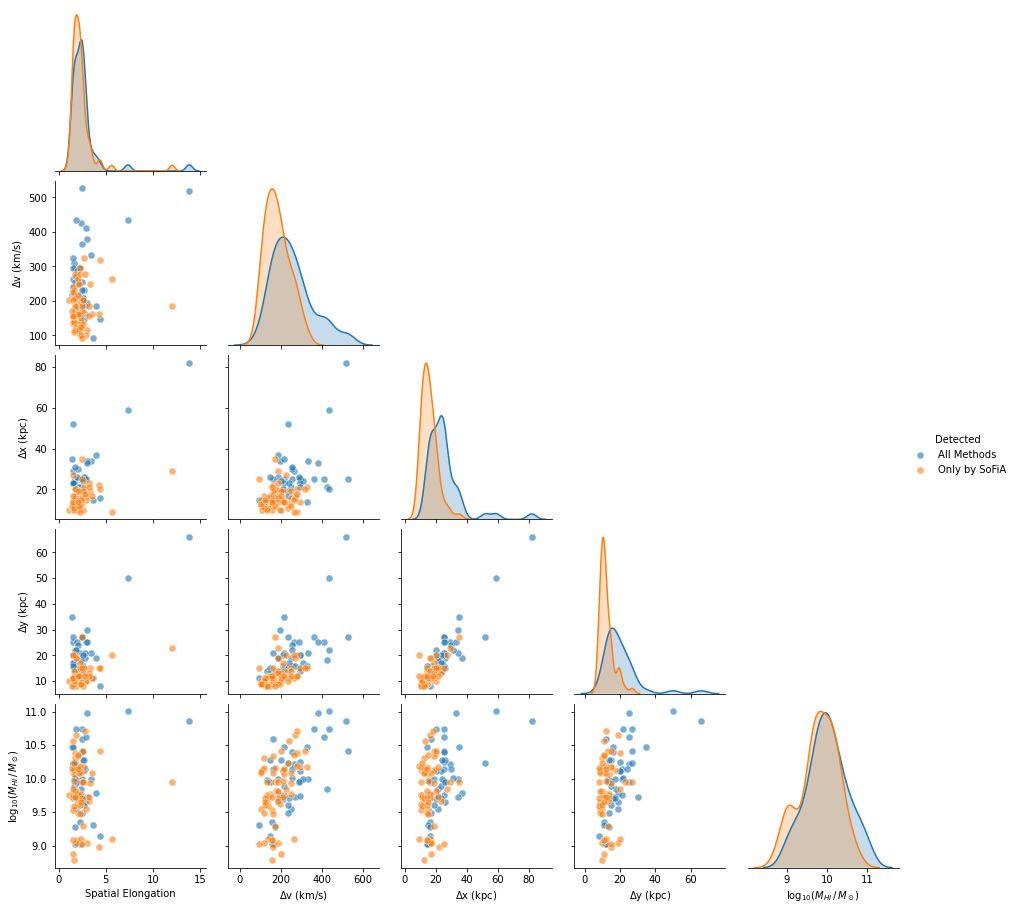

In [46]:
mto_real_list = (mto_real_df.mos_name_mask + mto_real_df.label_mask.astype(int).astype(str)).to_list()
sofia_real_list = (sofia_real_df.mos_name_mask + sofia_real_df.label_mask.astype(int).astype(str)).to_list()
vnet_real_list = (vnet_real_df.mos_name_mask + vnet_real_df.label_mask.astype(int).astype(str)).to_list()
h_0 = 70*u.km/(u.Mpc*u.s)
only_by_sofia = real_cat_df[(real_cat_df.mos_name + real_cat_df.label.astype(str)).apply(lambda x: (x not in mto_real_list) & (x not in vnet_real_list) & (x in sofia_real_list))]
only_by_sofia["tot_flux"] = only_by_sofia.fluxes.apply(lambda x: literal_eval(x)[0])
z = only_by_sofia.dist*u.Mpc*h_0/const.c.to(u.km/u.s)
only_by_sofia["log10mass"] = np.log10(2.35e5*only_by_sofia.tot_flux*(only_by_sofia.dist*u.Mpc)**2/((1+z)**2))
only_by_sofia = only_by_sofia[["elongation", "n_vel", "nx", "ny", "log10mass"]]
only_by_sofia.columns = labels[:-1]
only_by_sofia["Detected"] = "Only by SoFiA"

all_methods = real_cat_df[(real_cat_df.mos_name + real_cat_df.label.astype(str)).apply(lambda x: (x in mto_real_list) & (x in vnet_real_list) & (x in sofia_real_list))]
all_methods["tot_flux"] = all_methods.fluxes.apply(lambda x: literal_eval(x)[0])
z = all_methods.dist*u.Mpc*h_0/const.c.to(u.km/u.s)
all_methods["log10mass"] = np.log10(2.35e5*all_methods.tot_flux*(all_methods.dist*u.Mpc)**2/((1+z)**2))
all_methods = all_methods[["elongation", "n_vel", "nx", "ny", "log10mass"]]
all_methods.columns = labels[:-1]
all_methods["Detected"] = "All Methods"

# sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
g = sns.pairplot(all_methods.append(only_by_sofia), hue = 'Detected',
             diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 50},
#              size = 4
             corner=True
            )

<ipython-input-47-64aca96b1ec7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_by_vnet["tot_flux"] = only_by_vnet.fluxes.apply(lambda x: literal_eval(x)[0])
<ipython-input-47-64aca96b1ec7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_by_vnet["log10mass"] = np.log10(2.35e5*only_by_vnet.tot_flux*(only_by_vnet.dist*u.Mpc)**2/((1+z)**2))
<ipython-input-47-64aca96b1ec7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

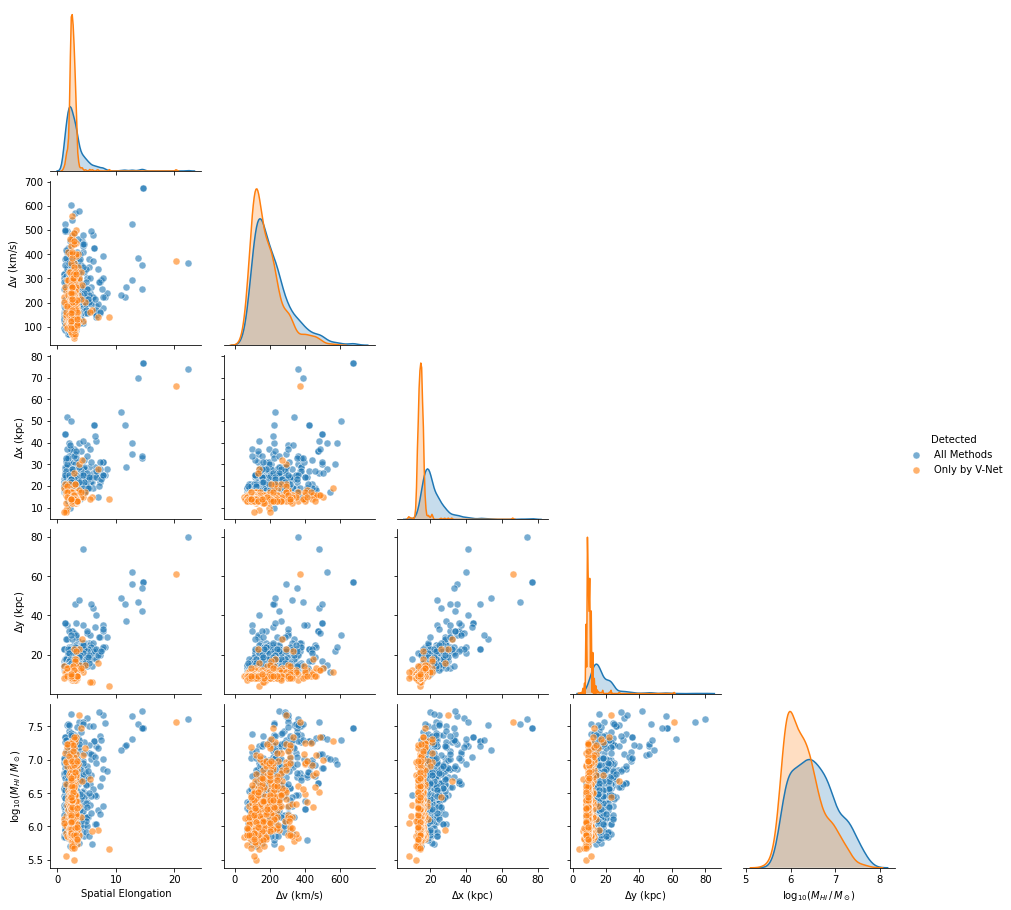

In [47]:
mto_mock_list = (mto_mock_df.mos_name_mask + mto_mock_df.label_mask.astype(int).astype(str)).to_list()
sofia_mock_list = (sofia_mock_df.mos_name_mask + sofia_mock_df.label_mask.astype(int).astype(str)).to_list()
vnet_mock_list = (vnet_mock_df.mos_name_mask + vnet_mock_df.label_mask.astype(int).astype(str)).to_list()
only_by_vnet = mock_cat_df[(mock_cat_df.mos_name + mock_cat_df.label.astype(int).astype(str)).apply(lambda x: (x not in mto_mock_list) & (x not in sofia_mock_list) & (x in vnet_mock_list))]
only_by_vnet["tot_flux"] = only_by_vnet.fluxes.apply(lambda x: literal_eval(x)[0])
z = only_by_vnet.dist*u.Mpc*h_0/const.c.to(u.km/u.s)
only_by_vnet["log10mass"] = np.log10(2.35e5*only_by_vnet.tot_flux*(only_by_vnet.dist*u.Mpc)**2/((1+z)**2))
only_by_vnet = only_by_vnet[["elongation", "n_vel", "nx", "ny", "log10mass"]]
only_by_vnet.columns = labels[:-1]
only_by_vnet["Detected"] = "Only by V-Net"

all_methods = mock_cat_df[(mock_cat_df.mos_name + mock_cat_df.label.astype(int).astype(str)).apply(lambda x: (x in mto_mock_list) & (x in vnet_mock_list) & (x in sofia_mock_list))]
all_methods["tot_flux"] = all_methods.fluxes.apply(lambda x: literal_eval(x)[0])
z = all_methods.dist*u.Mpc*h_0/const.c.to(u.km/u.s)
all_methods["log10mass"] = np.log10(2.35e5*all_methods.tot_flux*(all_methods.dist*u.Mpc)**2/((1+z)**2))
all_methods = all_methods[["elongation", "n_vel", "nx", "ny", "log10mass"]]
all_methods.columns = labels[:-1]
all_methods["Detected"] = "All Methods"

# sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
g = sns.pairplot(all_methods.append(only_by_vnet), hue = 'Detected',
             diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 50},
#              size = 4
             corner=True
            )

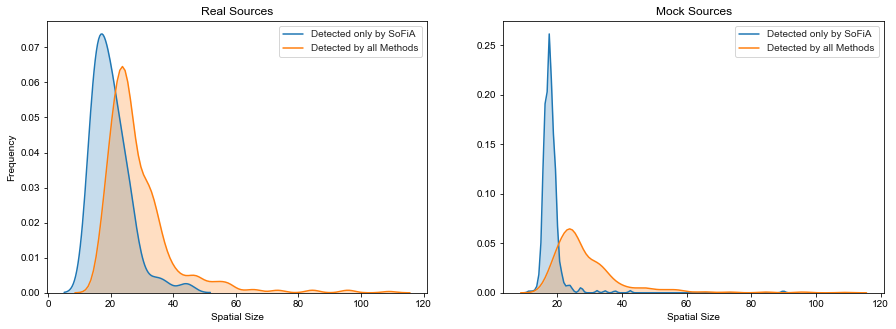

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), facecolor='white')
axes[0].set_title("Real Sources")
axes[1].set_title("Mock Sources")
sns.set_style("white")
sns.kdeplot(data=np.sqrt(only_by_sofia[r"$\Delta$x (kpc)"]**2 + only_by_sofia[r"$\Delta$y (kpc)"]**2 ), shade=True, label="Detected only by SoFiA", ax=axes[0])
sns.kdeplot(data=np.sqrt(all_methods[r"$\Delta$x (kpc)"]**2 + all_methods[r"$\Delta$y (kpc)"]**2 ), shade=True, label="Detected by all Methods", ax=axes[0])
axes[0].legend()
axes[0].set_xlabel("Spatial Size")
axes[0].set_ylabel("Frequency")
sns.kdeplot(data=np.sqrt(only_by_vnet[r"$\Delta$x (kpc)"]**2 + only_by_vnet[r"$\Delta$y (kpc)"]**2 ), shade=True, label="Detected only by SoFiA", ax=axes[1])
sns.kdeplot(data=np.sqrt(all_methods[r"$\Delta$x (kpc)"]**2 + all_methods[r"$\Delta$y (kpc)"]**2 ), shade=True, label="Detected by all Methods", ax=axes[1])
axes[1].set_xlabel("Spatial Size")
axes[1].legend()
plt.show()



In [49]:
only_by_sofia = real_cat_df[(real_cat_df.mos_name + real_cat_df.label.astype(str)).apply(lambda x: (x not in mto_real_list) & (x not in vnet_real_list) & (x in sofia_real_list))]
all_methods = real_cat_df[(real_cat_df.mos_name + real_cat_df.label.astype(str)).apply(lambda x: (x in mto_real_list) & (x in vnet_real_list) & (x in sofia_real_list))]
only_by_sofia["ny_arcsec"] = [np.arctan(row.ny*u.kpc/(row.dist*u.Mpc)).to(u.arcsec).value for i, row in only_by_sofia.iterrows()]
only_by_sofia["nx_arcsec"] = [np.arctan(row.nx*u.kpc/(row.dist*u.Mpc)).to(u.arcsec).value for i, row in only_by_sofia.iterrows()]
all_methods["ny_arcsec"] = [np.arctan(row.ny*u.kpc/(row.dist*u.Mpc)).to(u.arcsec).value for i, row in all_methods.iterrows()]
all_methods["nx_arcsec"] = [np.arctan(row.nx*u.kpc/(row.dist*u.Mpc)).to(u.arcsec).value for i, row in all_methods.iterrows()]

<ipython-input-49-9ee413af6fac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_by_sofia["ny_arcsec"] = [np.arctan(row.ny*u.kpc/(row.dist*u.Mpc)).to(u.arcsec).value for i, row in only_by_sofia.iterrows()]
<ipython-input-49-9ee413af6fac>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_by_sofia["nx_arcsec"] = [np.arctan(row.nx*u.kpc/(row.dist*u.Mpc)).to(u.arcsec).value for i, row in only_by_sofia.iterrows()]
<ipython-input-49-9ee413af6fac>:5: SettingWithCopyWarning: 
A value is trying to be set on

In [56]:
all_methods.mos_name.unique()


array(['1245mosC', '1245mosD', '1245mosE', '1245mosG', '1353mosC',
       '1353mosD', '1353mosE'], dtype=object)

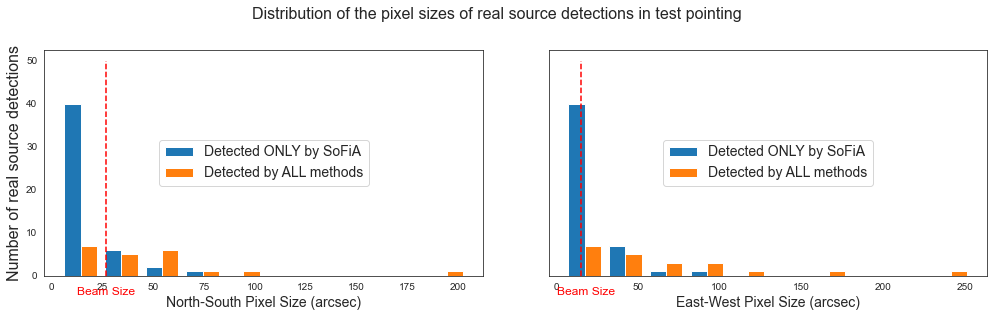

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True, facecolor='white')
fig.suptitle("Distribution of the pixel sizes of real source detections in test pointing", fontsize=16)
ax1.hist([only_by_sofia[only_by_sofia.mos_name.str.contains("1245")].ny_arcsec, all_methods[all_methods.mos_name.str.contains("1245")].ny_arcsec], label=["Detected ONLY by SoFiA", "Detected by ALL methods"])
ax1.legend(fontsize=14, loc='center')
ax1.vlines(27, 0, 50, linestyle="--", color="r")
ax1.set_xlabel("North-South Pixel Size (arcsec)", fontsize=14)
ax1.set_ylabel("Number of real source detections", fontsize=16)
ax1.text(27, -.05, 'Beam Size', color='red', transform=ax1.get_xaxis_transform(),
            ha='center', va='top', fontsize=12)

ax2.hist([only_by_sofia[only_by_sofia.mos_name.str.contains("1245")].nx_arcsec, all_methods[all_methods.mos_name.str.contains("1245")].nx_arcsec], label=["Detected ONLY by SoFiA", "Detected by ALL methods"])
ax2.legend(fontsize=14, loc='center')
ax2.vlines(15, 0, 50, linestyle="--", color="r")
ax2.set_xlabel("East-West Pixel Size (arcsec)", fontsize=14)
ax2.text(263, -.05, 'Beam Size', color='red', transform=ax1.get_xaxis_transform(),
            ha='center', va='top', fontsize=12)

fig.tight_layout(pad=5)

In [51]:
not_found_by_mto = real_cat_df[(real_cat_df.mos_name + real_cat_df.label.astype(str)).apply(lambda x: (x not in mto_real_list) & (x in vnet_real_list) & (x in sofia_real_list))]
not_found_by_mto["tot_flux"] = not_found_by_mto.fluxes.apply(lambda x: literal_eval(x)[0])
z = not_found_by_mto.dist*u.Mpc*h_0/const.c.to(u.km/u.s)
not_found_by_mto["log10mass"] = np.log10(2.35e5*not_found_by_mto.tot_flux*(not_found_by_mto.dist*u.Mpc)**2/((1+z)**2))
not_found_by_mto = not_found_by_mto[["elongation", "n_vel", "nx", "ny", "log10mass"]]
not_found_by_mto["Detected by MTO"] = "NO"

found_by_mot = real_cat_df[(real_cat_df.mos_name + real_cat_df.label.astype(str)).apply(lambda x: (x in mto_real_list))]
found_by_mot["tot_flux"] = found_by_mot.fluxes.apply(lambda x: literal_eval(x)[0])
z = found_by_mot.dist*u.Mpc*h_0/const.c.to(u.km/u.s)
found_by_mot["log10mass"] = np.log10(2.35e5*found_by_mot.tot_flux*(found_by_mot.dist*u.Mpc)**2/((1+z)**2))
found_by_mot = found_by_mot[["elongation", "n_vel", "nx", "ny", "log10mass"]]
found_by_mot["Detected by MTO"] = "YES"

<ipython-input-51-d19ad6ecffd3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_found_by_mto["tot_flux"] = not_found_by_mto.fluxes.apply(lambda x: literal_eval(x)[0])
<ipython-input-51-d19ad6ecffd3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_found_by_mto["log10mass"] = np.log10(2.35e5*not_found_by_mto.tot_flux*(not_found_by_mto.dist*u.Mpc)**2/((1+z)**2))
<ipython-input-51-d19ad6ecffd3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

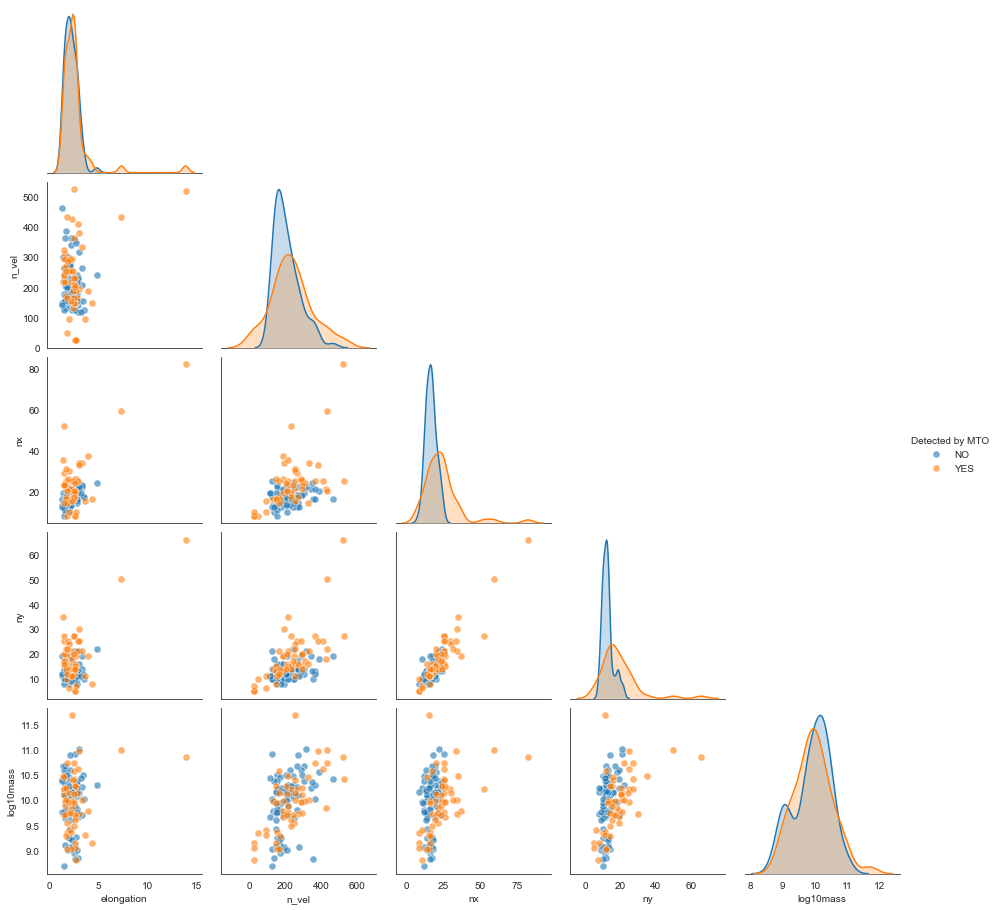

In [27]:
g = sns.pairplot(not_found_by_mto.append(found_by_mot), hue = 'Detected by MTO',
             diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 50},
#              size = 4
             corner=True
            )

<ipython-input-52-ac5ebf043fe2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_found_by_mto["tot_flux"] = not_found_by_mto.fluxes.apply(lambda x: literal_eval(x)[0])
<ipython-input-52-ac5ebf043fe2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_found_by_mto["log10mass"] = np.log10(2.35e5*not_found_by_mto.tot_flux*(not_found_by_mto.dist*u.Mpc)**2/((1+z)**2))
<ipython-input-52-ac5ebf043fe2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

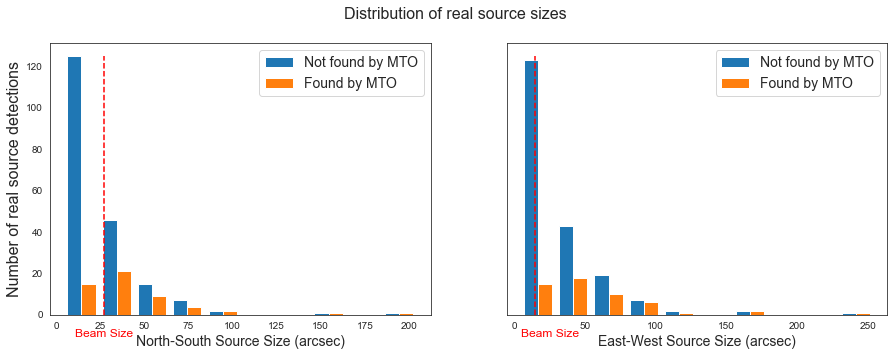

In [52]:
not_found_by_mto = real_cat_df[(real_cat_df.mos_name + real_cat_df.label.astype(str)).apply(lambda x: (x not in mto_real_list) & (x in vnet_real_list) | (x in sofia_real_list))]
not_found_by_mto["tot_flux"] = not_found_by_mto.fluxes.apply(lambda x: literal_eval(x)[0])
z = not_found_by_mto.dist*u.Mpc*h_0/const.c.to(u.km/u.s)
not_found_by_mto["log10mass"] = np.log10(2.35e5*not_found_by_mto.tot_flux*(not_found_by_mto.dist*u.Mpc)**2/((1+z)**2))

found_by_mot = real_cat_df[(real_cat_df.mos_name + real_cat_df.label.astype(str)).apply(lambda x: (x in mto_real_list))]
found_by_mot["tot_flux"] = found_by_mot.fluxes.apply(lambda x: literal_eval(x)[0])
z = found_by_mot.dist*u.Mpc*h_0/const.c.to(u.km/u.s)
found_by_mot["log10mass"] = np.log10(2.35e5*found_by_mot.tot_flux*(found_by_mot.dist*u.Mpc)**2/((1+z)**2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True, facecolor='white')
plt.suptitle("Distribution of real source sizes", fontsize=16)
not_found_by_mto["ny_arcsec"] = [np.arctan(row.ny*u.kpc/(row.dist*u.Mpc)).to(u.arcsec).value for i, row in not_found_by_mto.iterrows()]
not_found_by_mto["nx_arcsec"] = [np.arctan(row.nx*u.kpc/(row.dist*u.Mpc)).to(u.arcsec).value for i, row in not_found_by_mto.iterrows()]
found_by_mot["ny_arcsec"] = [np.arctan(row.ny*u.kpc/(row.dist*u.Mpc)).to(u.arcsec).value for i, row in found_by_mot.iterrows()]
found_by_mot["nx_arcsec"] = [np.arctan(row.nx*u.kpc/(row.dist*u.Mpc)).to(u.arcsec).value for i, row in found_by_mot.iterrows()]



ax1.hist([not_found_by_mto.ny_arcsec, found_by_mot.ny_arcsec], label=["Not found by MTO", "Found by MTO"])
ax1.legend(fontsize=14)
ax1.vlines(27, 0, 125, linestyle="--", color="r")
ax1.set_xlabel("North-South Source Size (arcsec)", fontsize=14)
ax1.set_ylabel("Number of real source detections", fontsize=16)
ax1.text(27, -.05, 'Beam Size', color='red', transform=ax1.get_xaxis_transform(),
            ha='center', va='top', fontsize=12)

ax2.hist([not_found_by_mto.nx_arcsec, found_by_mot.nx_arcsec], label=["Not found by MTO", "Found by MTO"])
ax2.legend(fontsize=14)
ax2.vlines(15, 0, 125, linestyle="--", color="r")
ax2.set_xlabel("East-West Source Size (arcsec)", fontsize=14)
ax2.text(280, -.05, 'Beam Size', color='red', transform=ax1.get_xaxis_transform(),
            ha='center', va='top', fontsize=12)

fig.tight_layout(pad=100)


**Answer**: I have plotted each of the properties of the detected real sources against each other for the test pointing, with the colour differentiating the source finding methods, see below. I think this nicely answers the question by showing how SoFiA managed to detect a lot more of the spatially smaller sources that MTO and V-Net missed. Perhaps even just a figure with the density plots would suffice?

**Question**: "The text mentions that V-Net may miss less regular sources as it was trained on regular, mock galaxies. If so, this should be easy to show. And what about MTObjects?"

In [26]:
cols = ["mos_name_mask", "label_mask", "fluxes", "tot_flux", "area_detection"]
sof_vnet_real_df = pd.merge(sofia_real_df[cols], vnet_real_df[cols], how="inner", on=["mos_name_mask", "label_mask"], suffixes=("_sofia", "_vnet"))
mto_vnet_real_df = pd.merge(mto_real_df[cols], vnet_real_df[cols], how="inner", on=["mos_name_mask", "label_mask"], suffixes=("_mto", "_vnet"))
sof_vnet_real_df["ratio"] = sof_vnet_real_df.tot_flux_sofia/sof_vnet_real_df.tot_flux_vnet
mto_vnet_real_df["ratio"] = mto_vnet_real_df.tot_flux_mto/sof_vnet_real_df.tot_flux_vnet

sof_vnet_mock_df = pd.merge(sofia_mock_df[cols], vnet_mock_df[cols], how="inner", on=["mos_name_mask", "label_mask"], suffixes=("_sofia", "_vnet"))
mto_vnet_mock_df = pd.merge(mto_mock_df[cols], vnet_mock_df[cols], how="inner", on=["mos_name_mask", "label_mask"], suffixes=("_mto", "_vnet"))
sof_vnet_mock_df["ratio"] = sof_vnet_mock_df.tot_flux_sofia/sof_vnet_mock_df.tot_flux_vnet
mto_vnet_mock_df["ratio"] = mto_vnet_mock_df.tot_flux_mto/sof_vnet_mock_df.tot_flux_vnet

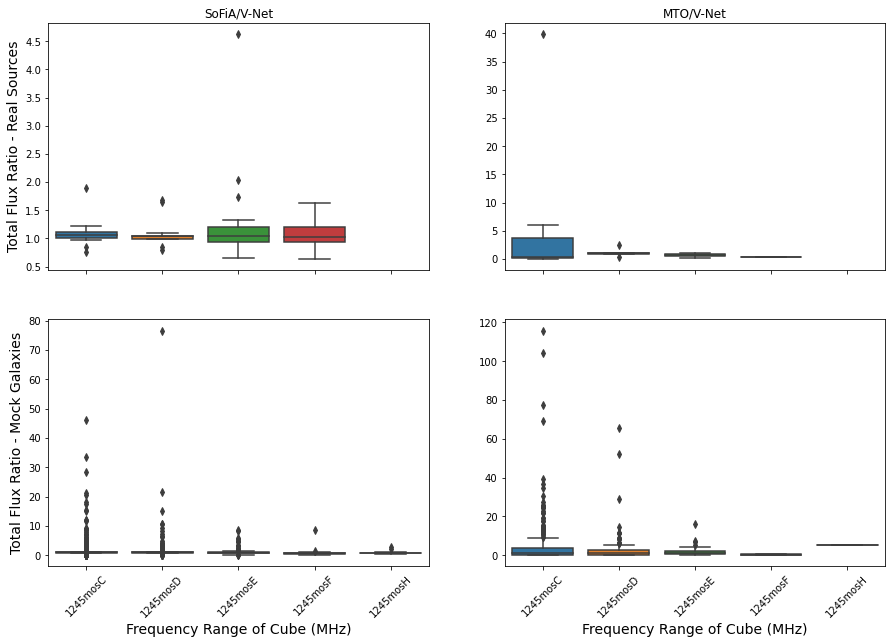

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(15,10), sharex=True, facecolor='white')

sns.boxplot(data=pd.merge(sof_vnet_real_df[sof_vnet_real_df.mos_name_mask.str.contains("1245")], freq_df, on="mos_name_mask", how='left'), x="mos_name_mask", y="ratio", ax=axes[0][0])
axes[0][0].set_ylabel(r"Total Flux Ratio - Real Sources", fontsize=14)
sns.boxplot(data=pd.merge(mto_vnet_real_df[mto_vnet_real_df.mos_name_mask.str.contains("1245")], freq_df, on="mos_name_mask", how='left'), x="mos_name_mask", y="ratio", ax=axes[0][1])
axes[0][0].set_xlabel("")
axes[0][1].set_xlabel("")
axes[0][0].set_title("SoFiA/V-Net")

sns.boxplot(data=pd.merge(sof_vnet_mock_df[sof_vnet_mock_df.mos_name_mask.str.contains("1245")], freq_df, on="mos_name_mask", how='left'), x="mos_name_mask", y="ratio", ax=axes[1][0])
axes[1][0].set_xticklabels(axes[1][0].get_xticklabels(), rotation=45)
axes[1][0].set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
axes[1][0].set_ylabel(r"Total Flux Ratio - Mock Galaxies", fontsize=14)

sns.boxplot(data=pd.merge(mto_vnet_mock_df[mto_vnet_mock_df.mos_name_mask.str.contains("1245")], freq_df, on="mos_name_mask", how='left'), x="mos_name_mask", y="ratio", ax=axes[1][1])
axes[1][1].set_xticklabels(axes[1][1].get_xticklabels(), rotation=45)
axes[1][1].set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
axes[1][1].set_ylabel("")
axes[0][1].set_ylabel("")
axes[0][1].set_title("MTO/V-Net")
plt.show()

**Answer**: I think I might have phrased this confusingly in the paper, because it is not that V-Net may miss less regular sources, but that it might fail to fully mask less regular sources. Which I feel is demonstrated sufficiently by Figure 7.

1. What is so different about the closest plot 1245mosC that there are so many False Positives?
    - Look for ripples
2. What is so similar or different about the False Positives?
    - Do they populate the same channels

**Question**: "Fig. 8 shows that there is nearly no overlap between the three samples of false detections. This begs the question of what is the difference between the three samples. Do they populate different regions of some parameter space? If so, what are the relevant source parameters, and why do different source finders pick such different false detections? This would likely have important implications for choosing the best source finder for a given HI science question. Alternatively, if the authors can show that no clear difference between the three samples can be found, it will be clear that more work needs to be done to compare these source finders."

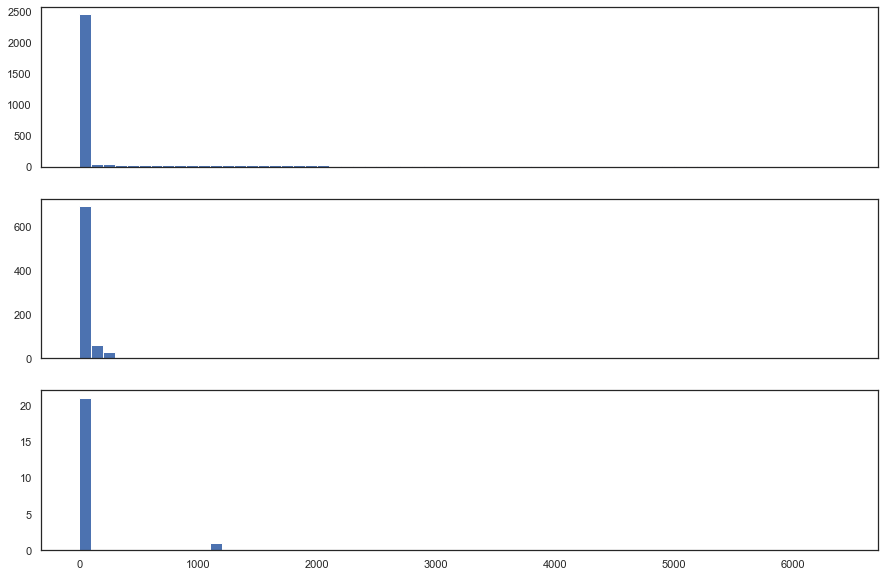

In [313]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10), facecolor='white', sharex=True)
binwidth = 100
data = mto_cat_df[mto_cat_df.mos_name.str.contains("1245mosH") & (mto_cat_df.type.isnull()) & (np.isfinite(mto_cat_df.elongation))].elongation
bins1=range(int(min(data)), int(max(data) + binwidth), binwidth)
ax1.hist(data, bins = bins1)
data = vnet_cat_df[vnet_cat_df.mos_name.str.contains("1245mosH") & (vnet_cat_df.type.isnull()) & (np.isfinite(vnet_cat_df.elongation))].elongation
bins1=range(int(min(data)), int(max(data) + binwidth), binwidth)
ax2.hist(data, bins = bins1)
data = sofia_cat_df[sofia_cat_df.mos_name.str.contains("1245mosH") & (sofia_cat_df.type.isnull()) & (np.isfinite(sofia_cat_df.elongation))].elongation
bins1=range(int(min(data)), int(max(data) + binwidth), binwidth)
ax3.hist(data, bins = bins1)

plt.show()

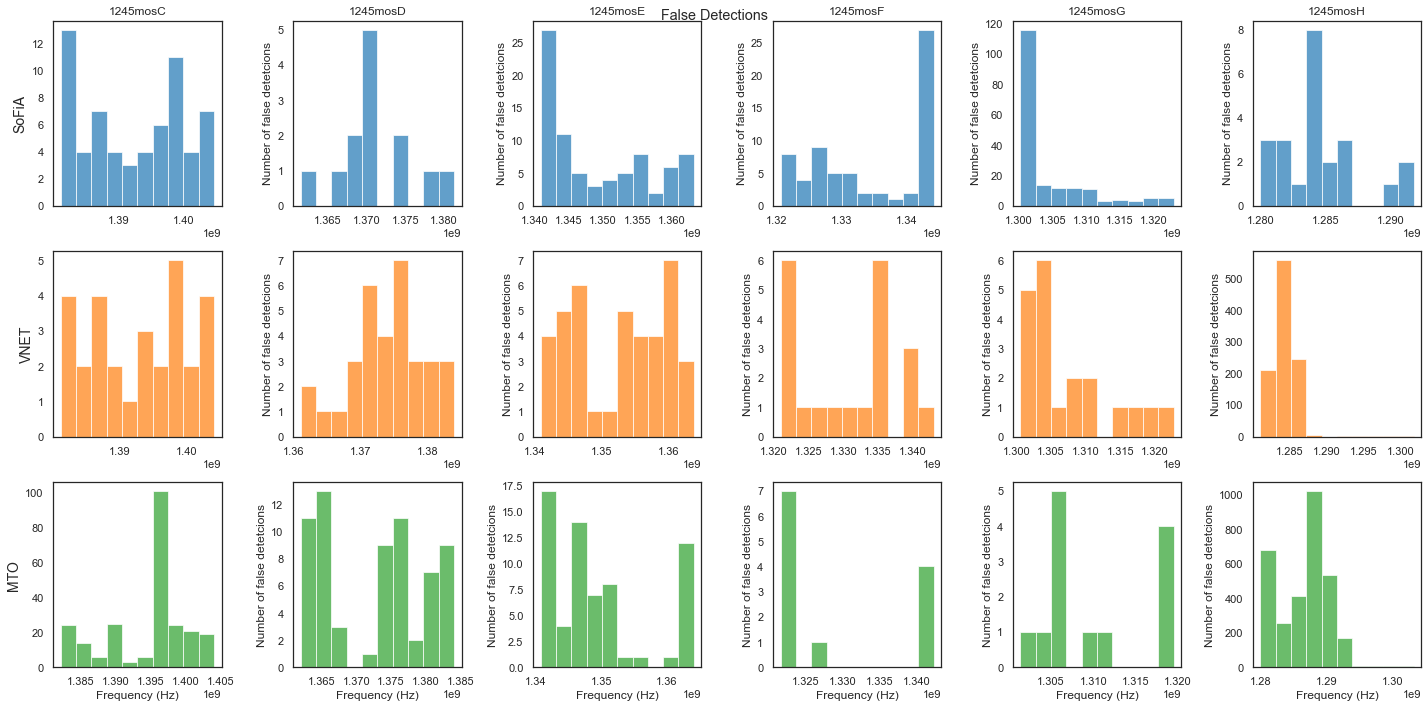

In [215]:
d_channels = 36621.09375*u.Hz
spec_range = {row.mos_name: np.arange(row.freq_1, row.freq_2, d_channels.value) for i, row in freq_df.iterrows()}
sofia_cat_df['freq'] = [spec_range[row.mos_name][int(row['centroid-0'])] for i, row in sofia_cat_df.iterrows()]
vnet_cat_df['freq'] = [spec_range[row.mos_name][int(row['centroid-0'])] for i, row in vnet_cat_df.iterrows()]
mto_cat_df['freq'] = [spec_range[row.mos_name][int(row['centroid-0'])] for i, row in mto_cat_df.iterrows()]
fig, axes = plt.subplots(3, 6, figsize=(20, 10), facecolor='white')
fig.suptitle("False Detections")
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c']
for j, method in enumerate([sofia_cat_df, vnet_cat_df, mto_cat_df]):
    for i, mos_name in enumerate(np.sort(sofia_cat_df[sofia_cat_df.mos_name.str.contains("1245")].mos_name.unique())):
            methodhist = method[(method.mos_name==mos_name) & method.type.isnull()].freq
            axes[j][i].hist(methodhist, color=colors[j], alpha=0.7, density=False)
            if j == 0:
                axes[j][i].set_title(mos_name)
            elif j == 2:
                axes[j][i].set_xlabel("Frequency (Hz)")
            axes[j][i].set_ylabel("Number of false detetcions")
axes[0][0].set_ylabel("SoFiA", fontsize=14)
axes[1][0].set_ylabel("VNET", fontsize=14)
axes[2][0].set_ylabel("MTO", fontsize=14)
fig.tight_layout()

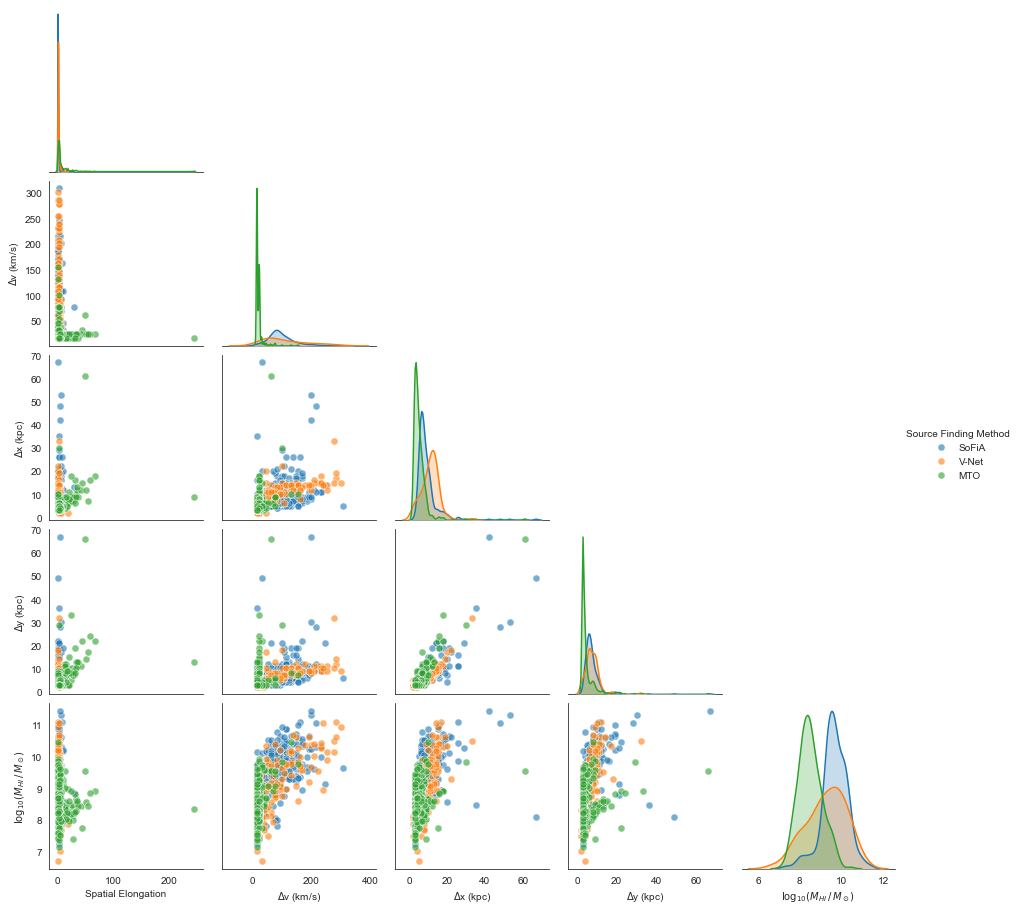

In [70]:
mto_fp_features = mto_cat_df[mto_cat_df.type.isnull() & (mto_cat_df.mos_name.str.contains("1245mos")) & (~mto_cat_df.mos_name.str.contains("1245mosH")) & (np.isfinite(mto_cat_df.elongation)) & (np.isfinite(mto_cat_df.log10mass))][["elongation", "n_vel", "nx", "ny", "log10mass"]]
mto_fp_features["method"] = "MTO"
mto_fp_features.columns = labels

sofia_fp_features = sofia_cat_df[sofia_cat_df.type.isnull() & (sofia_cat_df.mos_name.str.contains("1245mos")) & (~sofia_cat_df.mos_name.str.contains("1245mosH")) & (np.isfinite(sofia_cat_df.elongation)) & (np.isfinite(sofia_cat_df.log10mass))][["elongation", "n_vel", "nx", "ny", "log10mass"]]
sofia_fp_features["method"] = "SoFiA"
sofia_fp_features.columns = labels

vnet_fp_features = vnet_cat_df[vnet_cat_df.type.isnull() & (vnet_cat_df.mos_name.str.contains("1245mos")) & (~vnet_cat_df.mos_name.str.contains("1245mosH")) & (np.isfinite(vnet_cat_df.elongation)) & (np.isfinite(vnet_cat_df.log10mass))][["elongation", "n_vel", "nx", "ny", "log10mass"]]
vnet_fp_features["method"] = "V-Net"
vnet_fp_features.columns = labels

all_fp_features = sofia_fp_features.append(vnet_fp_features).append(mto_fp_features)
g = sns.pairplot(all_fp_features, hue = 'Source Finding Method',
             diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 50},
#              size = 4
             corner=True
            )

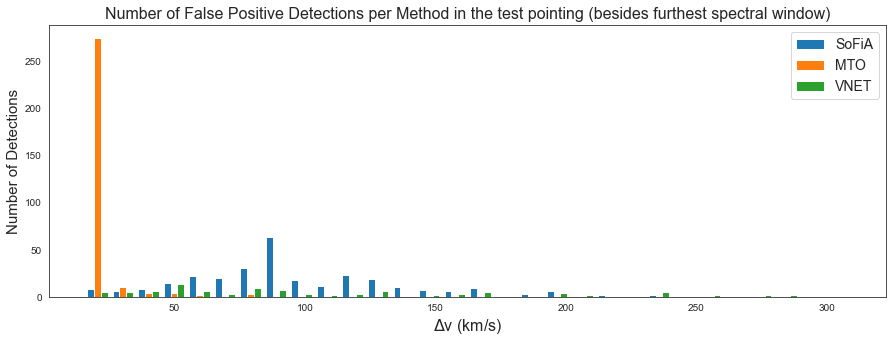

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5), facecolor='white', sharex=True)
col = r"$\Delta$v (km/s)"
myarray1 = sofia_fp_features[col]
myarray2 = mto_fp_features[col]
myarray3 = vnet_fp_features[col]

ax.hist([myarray1, myarray2, myarray3], label=["SoFiA", "MTO", "VNET"], bins=30)
ax.set_title("Number of False Positive Detections per Method in the test pointing (besides furthest spectral window)", fontsize=16)
ax.set_xlabel(col, fontsize=16)
ax.legend(fontsize=14)
ax.set_ylabel("Number of Detections", fontsize=15)
plt.show()

**Answer**: I have plotted the same plot as above, but this time for all false detections. This seems to show that the main issue with MTO and V-Net is accepting detections that are too massive and MTO accepts very elongated, spectrally wide detections - hence the benefit of a reliability filter or random forest classifier.

## Random Forest Questions

In [19]:
def evaluate(output_df, gt_df, mos_name, verbose=False):
    seg_df = output_df[output_df.mos_name == mos_name]
    tps = seg_df[~seg_df.type.isnull()]
    tp = len(tps)
    fp = len(seg_df) - tp
    fn = len(gt_df[gt_df.mos_name == mos_name]) - tp
    accuracy = tp/(fp+tp+fn)
    try:
        r = tp / (tp + fn)
    except ZeroDivisionError:
        r = 0
    try:
        p = tp / (tp + fp)
    except ZeroDivisionError:
        p = 0
    try:
        f_score = 2 * ((p * r) / (p + r))
    except ZeroDivisionError:
        f_score = 0
    um_score = np.mean((((tps.area_gt - tps.overlap_area) * tps.overlap_area)/tps.area_gt)/tps.detection_size)
    om_score = np.mean((((tps.area - tps.overlap_area) * tps.overlap_area)/tps.area)/tps.detection_size)
    area_score = 1 - np.sqrt((om_score ** 2) + (um_score ** 2))
    combined_one = np.sqrt((f_score ** 2) + (area_score ** 2))
    combined_two = np.cbrt((1 - om_score) * (1 - um_score) * f_score)
    if verbose:
        print("OUTSTAT True positive: ", tp)
        print("OUTSTAT False negative: ", fn)
        print("OUTSTAT False positive: ", fp)
        print("OUTSTAT Recall: ", r)
        print("OUTSTAT Precision: ", p)
        print("OUTSTAT F score: ", f_score)
        print("OUTSTAT Undermerging score:", um_score)
        print("OUTSTAT Overmerging score:", om_score)
        print("OUTSTAT Total area score:", area_score)
        print("OUTSTAT Combined A:", combined_one)
        print("OUTSTAT Combined B:", combined_two)
        
    return [mos_name, tp, fp, fn, r, p, f_score, accuracy, um_score, om_score, area_score, combined_one, combined_two]

In [20]:
def make_eval_df(source_props_df, mask_cat_df):
    eval_df = pd.DataFrame(columns=['mos_name', 'tp', 'fp', 'fn', 'recall', 'precision', 'f_score', 'accuracy', 'um', 'om',
           'area_score', 'combined_one', 'combined_two'])
    for mos_name in mask_cat_df.mos_name.unique():
        eval_df = eval_df.append(pd.Series(evaluate(source_props_df, mask_cat_df, mos_name), index = eval_df.columns), ignore_index=True)
    eval_df = pd.merge(freq_df[['mos_name', 'freq_1', 'freq_labels']], eval_df, on="mos_name", how="right")
    return eval_df

In [21]:
full_sofia_df = make_eval_df(sofia_cat_df, mask_cat_df)
full_mto_df = make_eval_df(mto_cat_df, mask_cat_df)
full_vnet_df = make_eval_df(vnet_cat_df, mask_cat_df)

<ipython-input-22-1abc46703c1a>:43: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


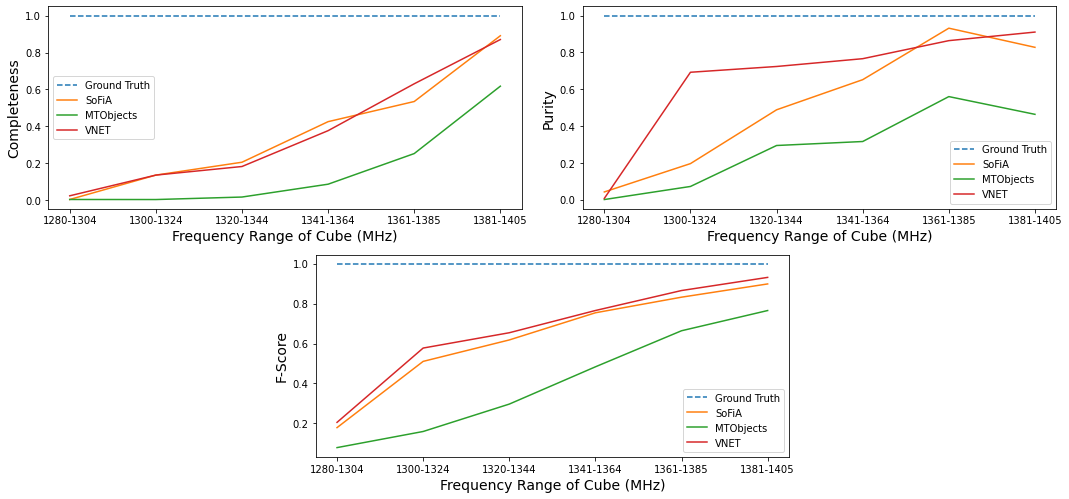

In [22]:
fig = plt.figure(constrained_layout=True, figsize=(15,10))
gs = fig.add_gridspec(3, 4)
ax1 = fig.add_subplot(gs[0, :2])
ax1.set_ylabel("Completeness", fontsize=14)
ax1.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax1.plot([1]*6, label="Ground Truth", linestyle="--")
sof = full_sofia_df[full_sofia_df.mos_name.str.contains("1245")].sort_values('freq_labels')
mto = full_mto_df[full_mto_df.mos_name.str.contains("1245")].sort_values('freq_labels')
vnet = full_vnet_df[full_vnet_df.mos_name.str.contains("1245")].sort_values('freq_labels')
ax1.plot(sof.freq_labels, sof.recall, label="SoFiA")
ax1.plot(mto.freq_labels, mto.recall, label="MTObjects")
ax1.plot(vnet.freq_labels, vnet.recall, label="VNET")
ax1.legend()

ax2 = fig.add_subplot(gs[0, 2:4])

ax2.set_ylabel("Purity", fontsize=14)
ax2.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax2.plot([1]*6, label="Ground Truth", linestyle="--")
ax2.plot(sof.freq_labels, sof.precision, label="SoFiA")
ax2.plot(mto.freq_labels, mto.precision, label="MTObjects")
ax2.plot(vnet.freq_labels, vnet.precision, label="VNET")
ax2.legend()

ax5 = fig.add_subplot(gs[1, 1:3])
ax5.set_ylabel("F-Score", fontsize=14)
ax5.plot([1]*6, label="Ground Truth", linestyle="--")
ax5.plot(sof.freq_labels, sof.combined_two, label="SoFiA")
ax5.plot(mto.freq_labels, mto.combined_two, label="MTObjects")
ax5.plot(vnet.freq_labels, vnet.combined_two, label="VNET")
ax5.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax5.legend()

# ax6 = fig.add_subplot(gs[1, 2:4])
# ax6.set_ylabel("Accuracy", fontsize=14)
# ax6.plot([1]*7, label="Ground Truth", linestyle="--")
# ax6.plot(sof.freq_labels, sof.accuracy, label="SoFiA")
# ax6.plot(mto.freq_labels, mto.accuracy, label="MTObjects")
# ax6.plot(vnet.freq_labels, vnet.accuracy, label="VNET")
# ax6.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
# ax6.legend()

fig.tight_layout()

In [23]:
sof_cat = sofia_cat_df[['mos_name', 'area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'true_positive_mocks', 'hi_mass', 'type']]
sof_cat["Class"] = 0
sof_cat.loc[sof_cat.true_positive_mocks | ~sof_cat.type.isnull(), "Class"] = 1
sof_cat["method"] = "sofia"
sof_cat = sof_cat[['mos_name', 'method', 'area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'hi_mass', 'Class']]
mto_cat = mto_cat_df[['mos_name', 'area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'true_positive_mocks', 'hi_mass', 'type']]
mto_cat["Class"] = 0
mto_cat.loc[mto_cat.true_positive_mocks | ~mto_cat.type.isnull(), "Class"] = 1
mto_cat["method"] = "mto"
mto_cat = mto_cat[['mos_name', 'method', 'area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'hi_mass', 'Class']]
vnet_cat = vnet_cat_df[['mos_name', 'area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'true_positive_mocks', 'hi_mass', 'type']]
vnet_cat["Class"] = 0
vnet_cat.loc[vnet_cat.true_positive_mocks | ~vnet_cat.type.isnull(), "Class"] = 1
vnet_cat["method"] = "vnet"
vnet_cat = vnet_cat[['mos_name', 'method', 'area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'hi_mass', 'Class']]
full_cat = sof_cat.append(vnet_cat).append(mto_cat)

full_cat = full_cat[~full_cat.elongation.isnull() & ~full_cat.hi_mass.isnull() & np.isfinite(full_cat.elongation) & np.isfinite(full_cat.hi_mass)]
x_train = full_cat[full_cat.mos_name.str.contains("1353")][['area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'hi_mass']]
x_test = full_cat[full_cat.mos_name.str.contains("1245")][['area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'hi_mass']]
y_train = full_cat[full_cat.mos_name.str.contains("1353")].Class.astype(int)
y_test = full_cat[full_cat.mos_name.str.contains("1245")].Class.astype(int)

<ipython-input-23-d2f435ea86f6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sof_cat["Class"] = 0
C:\Progra~1\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-23-d2f435ea86f6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [24]:
model = RandomForestClassifier(class_weight='balanced', max_depth=12)
model.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12)

In [25]:
new_sof_test = sofia_cat_df[sofia_cat_df.mos_name.str.contains("1245")]
ml_new_sof = new_sof_test[~new_sof_test.elongation.isnull() & ~new_sof_test.hi_mass.isnull() & np.isfinite(new_sof_test.elongation) & np.isfinite(new_sof_test.hi_mass)].copy(deep=True)
ml_new_sof["prediction"] = model.predict(ml_new_sof[['area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'hi_mass']])
rejected_sof = ml_new_sof[ml_new_sof.prediction == 0]
ml_new_sof = ml_new_sof[ml_new_sof.prediction == 1]
new_full_sofia_df = make_eval_df(ml_new_sof, mask_cat_df)

new_mto_test = mto_cat_df[mto_cat_df.mos_name.str.contains("1245")]
ml_new_mto = new_mto_test[~new_mto_test.elongation.isnull() & ~new_mto_test.hi_mass.isnull() & np.isfinite(new_mto_test.elongation) & np.isfinite(new_mto_test.hi_mass)].copy(deep=True)
ml_new_mto["prediction"] = model.predict(ml_new_mto[['area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'hi_mass']])
rejected_mto = ml_new_mto[ml_new_mto.prediction == 0]
ml_new_mto = ml_new_mto[ml_new_mto.prediction == 1]
new_full_mto_df = make_eval_df(ml_new_mto, mask_cat_df)

new_vnet_test = vnet_cat_df[vnet_cat_df.mos_name.str.contains("1245")]
ml_new_vnet = new_vnet_test[~new_vnet_test.elongation.isnull() & ~new_vnet_test.hi_mass.isnull() & np.isfinite(new_vnet_test.elongation) & np.isfinite(new_vnet_test.hi_mass)].copy(deep=True)
ml_new_vnet["prediction"] = model.predict(ml_new_vnet[['area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'hi_mass']])
rejected_vnet = ml_new_vnet[ml_new_vnet.prediction == 0]
ml_new_vnet = ml_new_vnet[ml_new_vnet.prediction == 1]
new_full_vnet_df = make_eval_df(ml_new_vnet, mask_cat_df)

<ipython-input-99-7debb96b8cfa>:43: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


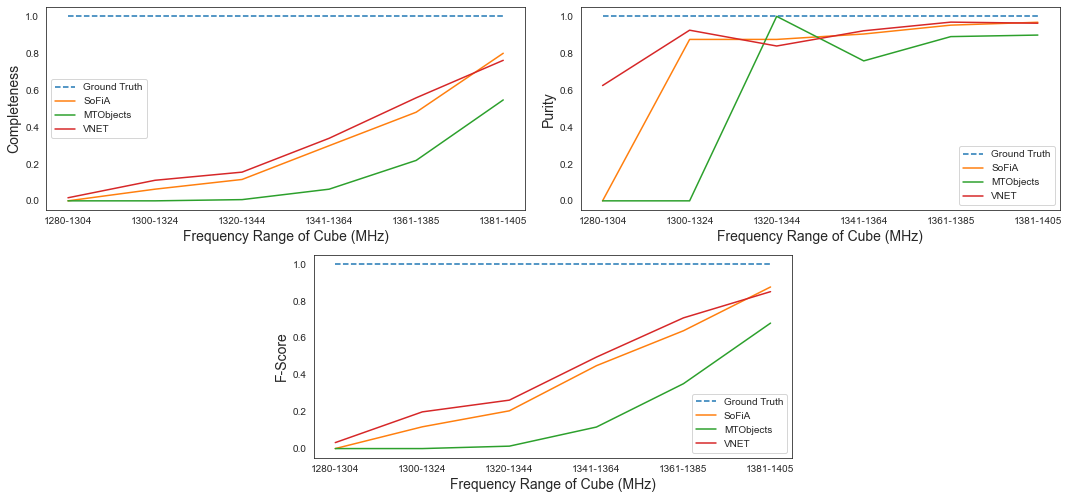

In [99]:
fig = plt.figure(constrained_layout=True, figsize=(15,10))
gs = fig.add_gridspec(3, 4)
ax1 = fig.add_subplot(gs[0, :2])
ax1.set_ylabel("Completeness", fontsize=14)
ax1.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax1.plot([1]*6, label="Ground Truth", linestyle="--")
sof = new_full_sofia_df[new_full_sofia_df.mos_name.str.contains("1245")].sort_values('freq_labels')
mto = new_full_mto_df[new_full_mto_df.mos_name.str.contains("1245")].sort_values('freq_labels')
vnet = new_full_vnet_df[new_full_vnet_df.mos_name.str.contains("1245")].sort_values('freq_labels')
ax1.plot(sof.freq_labels, sof.recall, label="SoFiA")
ax1.plot(mto.freq_labels, mto.recall, label="MTObjects")
ax1.plot(vnet.freq_labels, vnet.recall, label="VNET")
ax1.legend()

ax2 = fig.add_subplot(gs[0, 2:4])

ax2.set_ylabel("Purity", fontsize=14)
ax2.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax2.plot([1]*6, label="Ground Truth", linestyle="--")
ax2.plot(sof.freq_labels, sof.precision, label="SoFiA")
ax2.plot(mto.freq_labels, mto.precision, label="MTObjects")
ax2.plot(vnet.freq_labels, vnet.precision, label="VNET")
ax2.legend()

ax5 = fig.add_subplot(gs[1, 1:3])
ax5.set_ylabel("F-Score", fontsize=14)
ax5.plot([1]*6, label="Ground Truth", linestyle="--")
ax5.plot(sof.freq_labels, sof.f_score, label="SoFiA")
ax5.plot(mto.freq_labels, mto.f_score, label="MTObjects")
ax5.plot(vnet.freq_labels, vnet.f_score, label="VNET")
ax5.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax5.legend()

# ax6 = fig.add_subplot(gs[1, 2:4])
# ax6.set_ylabel("Accuracy", fontsize=14)
# ax6.plot([1]*7, label="Ground Truth", linestyle="--")
# ax6.plot(sof.freq_labels, sof.accuracy, label="SoFiA")
# ax6.plot(mto.freq_labels, mto.accuracy, label="MTObjects")
# ax6.plot(vnet.freq_labels, vnet.accuracy, label="VNET")
# ax6.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
# ax6.legend()

fig.tight_layout()

**Question**: "It is a little surprising that RF results in a significant improvement of the SoFiA catalogue given that SoFiA attempts to reject false detections. My point is whether the authors can comment on the properties of the SoFiA detections rejected by RF compared to the properties of the sources retained by RF. Do the two samples populate different regions of some parameter space? If so, which parameter space? Is it possible that the reliability algorithm of SoFiA ignores some important source parameters which could have helped separate true from false detections? Again, since the goal of this paper is to compare source finders, I think that this type of analysis needs to be added to highlight the strength/weaknesses of the various tools."

In [100]:
tree_results = pd.DataFrame([['area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
           'nx_kpc', 'ny_kpc', 'hi_mass'], model.feature_importances_]).T

tree_results.columns = ["Feature", "Random Forrest Importance"]
tree_results = tree_results.sort_values("Random Forrest Importance", ascending=False).reset_index(drop=True)
tree_results

,Feature,Random Forrest Importance
0,area,0.331396
1,ny_kpc,0.132603
2,nx_kpc,0.11592
3,hi_mass,0.110906
4,elongation,0.106483
5,n_vel,0.0761093
6,tot_flux,0.0717945
7,peak_flux,0.0547893


In [26]:
ml_new_vnet
# all_rejected = rejected_mto[~rejected_mto.type.isnull()].append(rejected_sof[~rejected_sof.type.isnull()]).append(rejected_vnet[~rejected_vnet.type.isnull()])
all_rejected = rejected_sof[~rejected_sof.type.isnull()]
all_rejected["Rejected"] = True
# all_kept = ml_new_mto.append(ml_new_sof).append(ml_new_vnet)
all_kept = ml_new_sof
all_kept["Rejected"] = False
all_df = all_rejected.append(all_kept)
all_df = all_df[['area',
 'log10mass',
 'ny_kpc',
 'nx_kpc',
 'elongation',
 'tot_flux',
 'n_vel',
 'peak_flux', 'Rejected']]
all_df.columns = ['Voxel Volume',
 '$\\log_{10}(M_{HI}\\,/\\,M_\\odot)$',
 '$\\Delta$y (kpc)',
 '$\\Delta$x (kpc)',
 'Spatial Elongation',
 r'Total Flux Jy$\,$km$\,$s$^{-1}$',
 '$\\Delta$v (km/s)',
 r'Peak Flux Jy$\,$km$\,$s$^{-1}$',
                  'Rejected by RF']

# sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
# g = sns.pairplot(all_df, hue='Rejected by RF',
#              diag_kind = 'kde',
#              plot_kws = {'alpha': 0.6, 's': 50},
# #              size = 4
#              corner=True
#             )

<ipython-input-26-bbbb40ae32bd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_rejected["Rejected"] = True


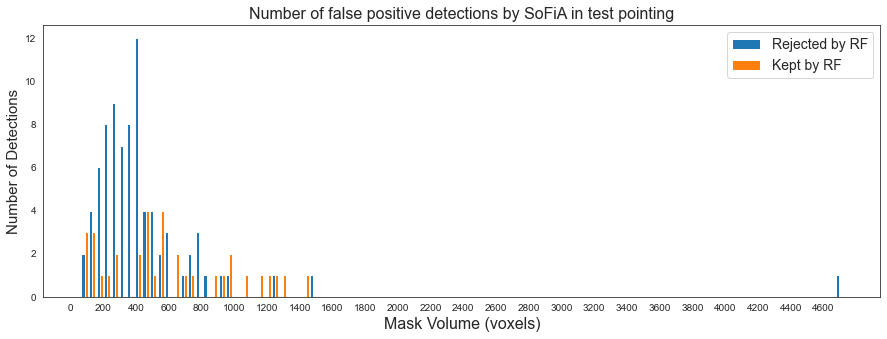

In [77]:
all_rejected = rejected_sof[~rejected_sof.type.isnull()]
all_kept = ml_new_sof[ml_new_sof.type.isnull()]
# all_rejected = all_rejected[['log10mass',
#  'n_vel', 'area']]
# all_kept = all_kept[['log10mass',
#  'n_vel', 'area']]
# all_rejected.columns = ['$\\log_{10}(M_{HI}\\,/\\,M_\\odot)$',
#  '$\\Delta$v (km/s)', 'Voxel Volume']

# all_kept.columns = ['$\\log_{10}(M_{HI}\\,/\\,M_\\odot)$',
#  '$\\Delta$v (km/s)', 'Voxel Volume']
fig, ax = plt.subplots(1, 1, figsize=(15, 5), facecolor='white', sharex=True)

col = 'area'
ax.set_title("Number of false positive detections by SoFiA in test pointing", fontsize=16)
ax.set_ylabel("Number of Detections", fontsize=15)
myarray1 = all_rejected[col]
myarray2 = all_kept[col]
# ax.set_xlim(0, 1500)
ax.hist([myarray1, myarray2], label=["Rejected by RF", "Kept by RF"], bins=100)

ax.set_xlabel("Mask Volume (voxels)", fontsize=16)
ax.legend(fontsize=14)
ax.set_xticks(np.arange(0, max(myarray1)+1, 200))

plt.show()

In [36]:
np.arange(min(myarray1), max(myarray1)+1, 500)

array([  90,  590, 1090, 1590, 2090, 2590, 3090, 3590, 4090, 4590])

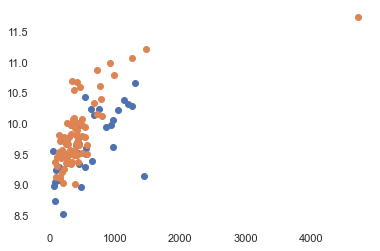

In [104]:
plt.scatter(all_kept.area, all_kept.log10mass)
plt.scatter(all_rejected.area, all_rejected.log10mass)
plt.show()

**Answer**: Plotting the same plot as above, but this time with the detections of SoFiA that are rejected vs. those that are kept by the Random Forest. I think the main thing here is the very low (flat line) voxel volume and fluxes, which are also the most important features ranked by the RF. This could suggest that SoFiA could better filter unreliable sources by setting conditions on the distribution of the voxel volume and fluxes?

### Final Score

In [105]:
real_vnet_df = make_eval_df(ml_new_vnet[ml_new_vnet.type != "mock"], mask_cat_df)
real_sofia_df = make_eval_df(ml_new_sof[ml_new_sof.type != "mock"], mask_cat_df)
real_mto_df = make_eval_df(ml_new_mto[ml_new_mto.type != "mock"], mask_cat_df)

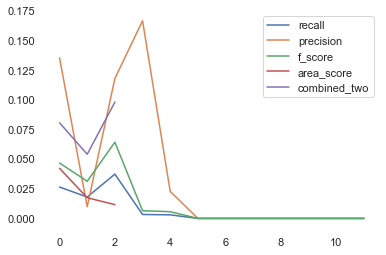

In [106]:
for col in ['recall', 'precision', 'f_score', 'area_score', 'combined_two']:
    plt.plot(real_sofia_df[col] - real_vnet_df[col], label=col)
plt.legend()
plt.show()

In [107]:
mock_vnet_df = make_eval_df(ml_new_vnet[ml_new_vnet.type != "real"], mask_cat_df)
mock_sofia_df = make_eval_df(ml_new_sof[ml_new_sof.type != "real"], mask_cat_df)
mock_mto_df = make_eval_df(ml_new_mto[ml_new_mto.type != "real"], mask_cat_df)

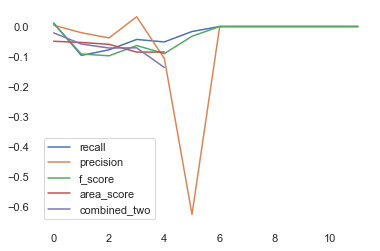

In [108]:
for col in ['recall', 'precision', 'f_score', 'area_score', 'combined_two']:
    plt.plot(mock_sofia_df[col] - mock_vnet_df[col], label=col)
plt.legend()
plt.show()